<a href="https://colab.research.google.com/github/Shkum/IT_STEP/blob/ML/Dota_analise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [277]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'small-nice-data-dota2:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1202763%2F2011027%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240319%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240319T105109Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Dbcf107894042d2831f7181f4857a42976d4d8ebadecae9c67d00965e69f31e98a388bed4a0ea9320c1c37f12d59eddec1782e8b72e60269f1cd9804ec2a5915fe3a236c4f58e1f37595975bb367fb01d8ceda4967836ed04813ac49fe349a327b27051017763a02bc474abe443efbd38e87001f406b1231958accb2701ec088ade6dcc52202f20c8f09a4966bf21cdfa83cabba0444fc2e0aa5d04eef462aae941cee62729b3b0b8f5715d9cfc24da4dcc3e29dde3ba81e7f3a6523a3526c68fc7892e2917ef85c46df0c47fb14ca2439a3115ee515f855863f4bc53b24071cafe8edacc8e139209f9bf99dffb55c8cba85d69bec2ff824e12ee604ac8a17dff'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 13551608 bytes downloaded
Downloaded and uncompressed: small-nice-data-dota2
Data source import complete.


In [278]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/small-nice-data-dota2/small_nice_data.csv


In [279]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import model_selection, metrics
import lightgbm as lgb

In [280]:
df = pd.read_csv("/kaggle/input/small-nice-data-dota2/small_nice_data.csv",
                 index_col=0)

In [281]:
df.head()

,time,radiant_roshankill,radiant_Δroshankill,dire_roshankill,dire_Δroshankill,good_tower1,good_tower2,good_tower3,good_melee,good_range,...,radiant_buyback,dire_buyback,radiant_Δrunes,dire_Δrunes,radiant_runes,dire_runes,radiant_aegis,dire_aegis,radiantΔaegis,direΔaegis
0,0,0,0,0,0,3,3,3,3,3,...,0,0,1,1,1,1,0,0,0,0
1,60,0,0,0,0,3,3,3,3,3,...,0,0,1,1,2,2,0,0,0,0
2,120,0,0,0,0,3,3,3,3,3,...,0,0,0,0,2,2,0,0,0,0
3,180,0,0,0,0,3,3,3,3,3,...,0,0,0,0,2,2,0,0,0,0
4,240,0,0,0,0,3,3,3,3,3,...,0,0,0,0,2,2,0,0,0,0


In [282]:
df['time'].describe()

count    164300.000000
mean       1072.197079
std         734.369752
min           0.000000
25%         480.000000
50%        1020.000000
75%        1560.000000
max        5820.000000
Name: time, dtype: float64

In [283]:
y = df['time']
X = df.drop(columns='time')

In [284]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

In [285]:
cat_columns = X.select_dtypes(include="object").columns
X[cat_columns] = X[cat_columns].astype('category')

In [286]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

In [287]:
num_columns = X.select_dtypes(include="number").columns
cat_columns = X.select_dtypes(include="category").columns

num_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median"))])

cat_transformer = Pipeline(
        steps=[("imputer", SimpleImputer(strategy="most_frequent")), ])

preprocessor = ColumnTransformer(
               transformers=[
                    ("num", num_transformer, num_columns),
                    ("cat", cat_transformer, cat_columns),])

preprocessor.set_output(transform='pandas')

preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median'))]),
                                 Index(['radiant_roshankill', 'radiant_Δroshankill', 'dire_roshankill',
       'dire_Δroshankill', 'good_tower1', 'good_tower2', 'good_tower3',
       'good_melee', 'good_range', 'good_fort', 'bad_tower1', 'bad_tower2',
       'bad_tower3', 'bad_melee', 'bad_range', 'bad_fort', 'id', 'y...
       'radiant_null_cost', 'dire_null_cost', 'radiant_Δkills', 'dire_Δkills',
       'radiant_kills', 'dire_kills', 'radiant_Δbuyback', 'dire_Δbuyback',
       'radiant_buyback', 'dire_buyback', 'radiant_Δrunes', 'dire_Δrunes',
       'radiant_runes', 'dire_runes', 'radiant_aegis', 'dire_aegis',
       'radiantΔaegis', 'direΔaegis'],
      dtype='object')),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent'))]),
                                 Index([], dtype='object'))])

In [288]:
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

In [289]:
#model = lgb.LGBMRegressor(objective='mse', max_depth=50, learning_rate=0.02, n_estimators=250 )
model = lgb.LGBMRegressor(objective='mse', learning_rate=0.02, n_estimators=250 )

In [290]:
model.fit(X_train, y_train,
          eval_set=[(X_test, y_test), (X_train, y_train)],
          eval_names = ['train', 'test'],
          eval_metric='mae')

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.075573 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8357
[LightGBM] [Info] Number of data points in the train set: 131440, number of used features: 82
[LightGBM] [Info] Start training from score 1072.303256


LGBMRegressor(learning_rate=0.02, n_estimators=250, objective='mse')

In [291]:
from sklearn import metrics

def get_metrics(y_true, y_pred, name="model"):
  df = pd.DataFrame()
  df.loc["MAE", name] = metrics.mean_absolute_error(y_true, y_pred)
  df.loc["RMSE", name] = metrics.mean_squared_error(y_true, y_pred) ** 0.5
  df.loc["R2", name] = metrics.r2_score(y_true, y_pred)

  return df.round(2)

In [292]:
all_metrics = pd.DataFrame()

all_metrics["train"] = get_metrics(y_train, model.predict(X_train))
all_metrics["test"] = get_metrics(y_test, model.predict(X_test))

all_metrics

,train,test
MAE,30.01,30.52
RMSE,43.77,44.99
R2,1.00,1.00


<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

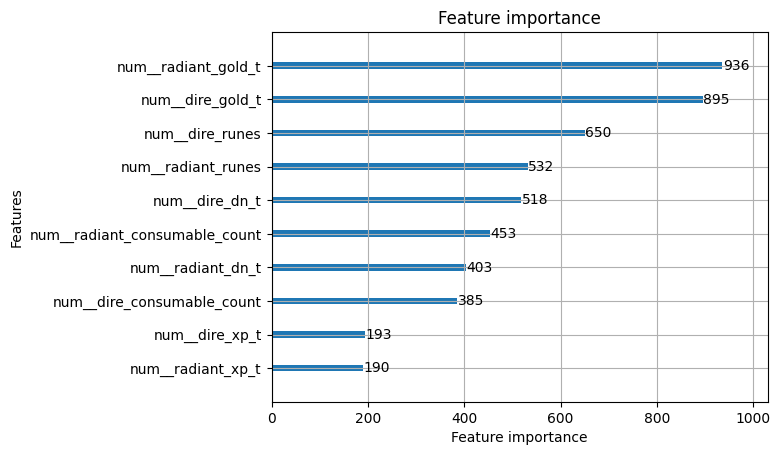

In [293]:
lgb.plot_importance(model, max_num_features=10)

<Axes: title={'center': 'Metric during training'}, xlabel='Iterations', ylabel='l1'>

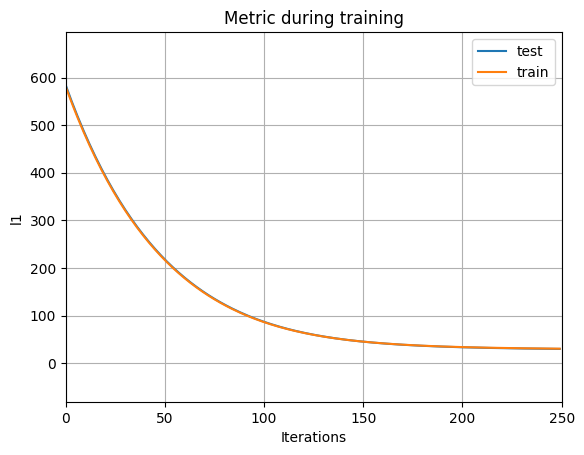

In [294]:
lgb.plot_metric(model,
                metric='l1')

In [295]:
model = Pipeline(
        [("prep", preprocessor),
         ("model", model)])

model

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  Index(['radiant_roshankill', 'radiant_Δroshankill', 'dire_roshankill',
       'dire_Δroshankill', 'good_tower1', 'good_tower2', 'good_tower3',
       'good_melee', 'good_range', 'good_fort', 'bad_tower1', 'bad_tower2',
       'bad_tower3', 'bad_melee', 'bad_r...
       'radiant_buyback', 'dire_buyback', 'radiant_Δrunes', 'dire_Δrunes',
       'radiant_runes', 'dire_runes', 'radiant_aegis', 'dire_aegis',
       'radiantΔaegis', 'direΔaegis'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  Index([], dtype='object'))])),
                ('model',
                 LGBMRegressor(learning_rate=0.02, n_estimators=250,
                               objective='mse'))])

In [296]:

import joblib
joblib.dump(model, 'my_model.pkl')

['my_model.pkl']

In [297]:
my_model = joblib.load('my_model.pkl')
my_model

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  Index(['radiant_roshankill', 'radiant_Δroshankill', 'dire_roshankill',
       'dire_Δroshankill', 'good_tower1', 'good_tower2', 'good_tower3',
       'good_melee', 'good_range', 'good_fort', 'bad_tower1', 'bad_tower2',
       'bad_tower3', 'bad_melee', 'bad_r...
       'radiant_buyback', 'dire_buyback', 'radiant_Δrunes', 'dire_Δrunes',
       'radiant_runes', 'dire_runes', 'radiant_aegis', 'dire_aegis',
       'radiantΔaegis', 'direΔaegis'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  Index([], dtype='object'))])),
                ('model',
                 LGBMRegressor(learning_rate=0.02, n_estimators=250,
                               objective='mse'))])

In [298]:
data = df.sample(1)
data

,time,radiant_roshankill,radiant_Δroshankill,dire_roshankill,dire_Δroshankill,good_tower1,good_tower2,good_tower3,good_melee,good_range,...,radiant_buyback,dire_buyback,radiant_Δrunes,dire_Δrunes,radiant_runes,dire_runes,radiant_aegis,dire_aegis,radiantΔaegis,direΔaegis
95189,2040,2,0,0,0,0,1,3,3,3,...,0,2,1,0,24,21,2,0,0,0


In [299]:
pred = model.predict(data)
pred

array([2085.90049042])

In [300]:
accurate = abs(1 - round(data['time'] / pred[0], 2))
accurate

95189    0.02
Name: time, dtype: float64